# Описание задачи

В задаче предоставлены данные транзакций от сектора онлайн-ритейла в Великобритании.

Цель задачи: повышение эффективности маркетинговых стратегий и увеличение продаж за счет сегментации клиентов.

**InvoiceNo**: номер транзакции, в одной транзакции может быть несколько продуктов  
**StockCode**: код продукта  
**Description**: описание продукта  
**Quantity**: количество продуктов в каждой транзакции  
**InvoiceDate**: дата и время транзакции  
**UnitPrice**: цена единицы товара в фунтах стерлингов  
**CustomerID**: уникальный идентификатор у каждого клиента  
**Country**: страна, где проведена транзакция  

**Импорт библиотек**

In [319]:
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from yellowbrick.cluster import KElbowVisualizer

In [52]:
df = pd.read_csv('data.csv', encoding="ISO-8859-1")
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom


# Предварительный анализ

In [53]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB


В столбцах Description и CustomerID пропущено много значений

In [54]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Quantity,541909.0,9.552250,218.081158,-80995.00,1.00,3.00,10.00,80995.0
UnitPrice,541909.0,4.611114,96.759853,-11062.06,1.25,2.08,4.13,38970.0
CustomerID,406829.0,15287.690570,1713.600303,12346.00,13953.00,15152.00,16791.00,18287.0


In [55]:
df.describe(include='object').T

,count,unique,top,freq
InvoiceNo,541909,25900,573585,1114
StockCode,541909,4070,85123A,2313
Description,540455,4223,WHITE HANGING HEART T-LIGHT HOLDER,2369
InvoiceDate,541909,23260,10/31/2011 14:41,1114
Country,541909,38,United Kingdom,495478


Выводы
1. В колонке Description пропущено 1454 значений
2. В колонке CustomerID пропущено 135080 значений
3. Наиболее частая страна в датасете - Великобритания, всего стран 38
4. Средняя цена единицы товара 4.61
5. Среднее количество товара в транзакции 9.55, отрицательные значения указывают на возврат товара.


# Очистка данных

## Проверка на количество пропущенных значений

In [56]:
df.isnull().sum().sum()

136534

Удаление пропущенных значений в колонке CustomerID

In [57]:
df.dropna(subset=['CustomerID'], inplace=True)

Удаление пропущенных значений в колонке Description

In [58]:
df.dropna(subset=['Description'], inplace=True)

Проверка на количество пропущенных значений после удаления

In [46]:
df.isnull().sum().sum()

0

In [59]:
df.shape

(406829, 8)

## Проверка на дубликаты в данных

In [60]:
print('Количество строк-дубликатов: ', df.duplicated().sum())

Количество строк-дубликатов:  5225


Удаление повторяющихся строк для улучшения кластеризации

In [61]:
df.drop_duplicates(inplace=True)

In [62]:
df.shape

(401604, 8)

## Изучение цены и количества товаров

Проверка на товары с ценой 0

In [64]:
df[df['UnitPrice'] == 0].describe()[['Quantity']].T

,count,mean,std,min,25%,50%,75%,max
Quantity,40.0,347.1,1978.311813,1.0,1.0,4.5,24.0,12540.0


Таких товаров всего 40, для лучшей кластеризации их удалим, потому что цена 0 может быть ошибкой в данных

In [256]:
df = df[df['UnitPrice'] > 0] # Оставили товары с положительной ценой

In [257]:
df.shape

(401564, 8)

Проверка на возврат товаров (отрициальное количество товаров)

In [271]:
df.Quantity.describe()

count    401564.000000
mean         12.149911
std         249.512649
min      -80995.000000
25%           2.000000
50%           5.000000
75%          12.000000
max       80995.000000
Name: Quantity, dtype: float64

Удалим товары, которые возвращали

In [273]:
df = df[df['Quantity'] > 0]

In [274]:
df.Quantity.describe()

count    392692.000000
mean         13.119702
std         180.492832
min           1.000000
25%           2.000000
50%           6.000000
75%          12.000000
max       80995.000000
Name: Quantity, dtype: float64

# Обработка выбросов в значениях

In [275]:
df.reset_index(drop=True, inplace=True)

# RFM-анализ
В RFM-анализе мы сегментируем покупателей на основе их поведения.   
**Recency** — как давно клиент в последний раз покупал у нас товар. Клиент, который делал это недавно, может быть больше вовлечен в компанию. А давний покупатель может быть неактивен.  
**Frequency** — как часто клиент у нас покупает. Если клиент часто покупает товары, это может говорить о высокой лояльности к компании.  
**Monetary** — насколько большой средний чек.  

Сегменты покупателей

**Champions** - покупали недавно, покупают часто и тратят больше всех  
**Loyal customers** - часто тратят хорошие деньги  
**Potential loyalist** - недавние клиенты, потратили приличную сумму  
**New customers** - покупали недавно, но не часто  
**Promising** - покупали недавно, но потратили немного      
**Needing attention** - показатели R,F,M выше среднего, возможно, покупки были недавно  
**About to sleep** - R, F, M показатели ниже среднего, рискуем потерять клиентов  
**At risk** - тратил большие деньги и покупал товары часто, но делал это давно, таких клиентов нужно возвращать  
**Can't loose them** - совершал крупные покупки и часто, но долго не возвращался    
**Hibernating** - последняя покупка была совершена давно, низкие траты и небольшое количество заказов  

In [276]:
today = dt.datetime(2011,12,12)

In [278]:
rfm_df = df.copy()
rfm_df['TotalPrice'] = rfm_df['Quantity'] * rfm_df['UnitPrice']

In [281]:
rfm_df['InvoiceDate'] = pd.to_datetime(rfm_df['InvoiceDate'])
rfm = rfm_df.groupby('CustomerID').agg({'InvoiceDate': lambda InvoiceDate: (today - InvoiceDate.max()).days,
                                    'InvoiceNo'    : lambda InvoiceNo: InvoiceNo.nunique(),
                                    'TotalPrice' : lambda TotalPrice: TotalPrice.sum()})

rfm.columns = ['Recency', 'Frequency', 'Monetary']

In [283]:
rfm['Recency_score'] = pd.qcut(rfm['Recency'], 5, labels=[5, 4, 3, 2, 1])
rfm['Frequency_score'] = pd.qcut(rfm['Frequency'].rank(method="first"), 5, labels=[1, 2, 3, 4, 5])
rfm['Monetary_score'] = pd.qcut(rfm['Monetary'], 5, labels=[1, 2, 3, 4, 5])

# Сокращаем 125 сегментов до 25, используя только оценки R и F
rfm['RFM_Score'] = (rfm['Recency_score'].astype(str) + rfm['Frequency_score'].astype(str))

In [284]:
rfm.head()

,Recency,Frequency,Monetary,Recency_score,Frequency_score,Monetary_score,RFM_Score
CustomerID,,,,,,,
12346.0,327,1,77183.60,1,1,5,11
12347.0,4,7,4310.00,5,5,5,55
12348.0,77,4,1797.24,2,4,4,24
12349.0,20,1,1757.55,4,1,4,41
12350.0,312,1,334.40,1,1,2,11


Сегменты покупателей

In [285]:
segments = {
    r'5[4-5]': 'Champions',
    r'[3-4][4-5]': 'Loyal customers',
    r'[4-5][2-3]': 'Potential loyalists',
    r'51': 'New customers',
    r'41': 'Promising',
    r'33': 'Needing attention',
    r'3[1-2]': 'About to sleep',
    r'[1-2][3-4]': 'At risk',
    r'[1-2]5': 'Cant loose',
    r'[1-2][1-2]': 'Hibernating',
}
rfm['Segment'] = rfm['RFM_Score'].replace(segments, regex=True)
rfm.reset_index(inplace=True)
rfm.head()

,CustomerID,Recency,Frequency,Monetary,Recency_score,Frequency_score,Monetary_score,RFM_Score,Segment
0,12346.0,327,1,77183.60,1,1,5,11,Hibernating
1,12347.0,4,7,4310.00,5,5,5,55,Champions
2,12348.0,77,4,1797.24,2,4,4,24,At risk
3,12349.0,20,1,1757.55,4,1,4,41,Promising
4,12350.0,312,1,334.40,1,1,2,11,Hibernating


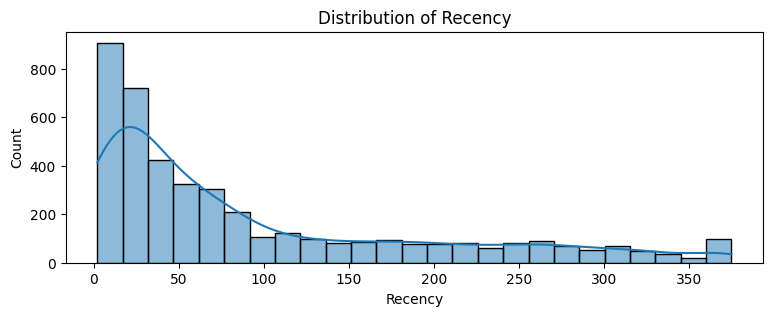

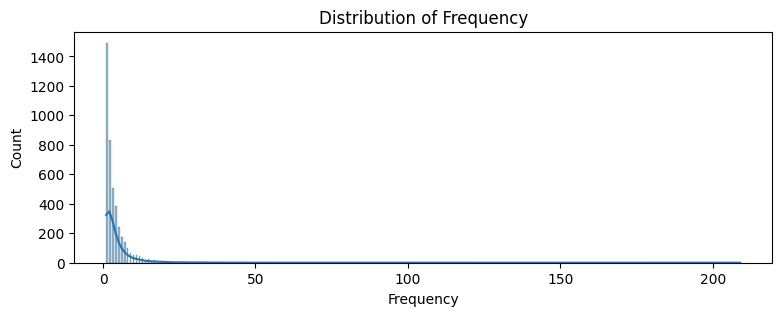

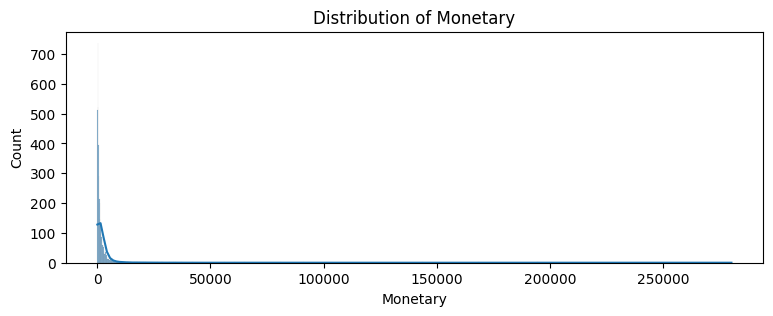

In [286]:
colnames = ['Recency', 'Frequency', 'Monetary']

for col in colnames:
    fig, ax = plt.subplots(figsize=(9,3))
    sns.histplot(rfm[col], kde=True)
    ax.set_title('Distribution of %s' % col)
    plt.show()

Распределение Recency (как давно совершена транзакция) смещено вправо, что показывает, что большинство клиентов совершали покупки в недавнем прошлом.

В распределении Monetary очень большой разброс, но приличная часть показателей находится до 50000

In [287]:
segments_count = rfm.groupby("Segment").agg({"CustomerID": "count"})
segments_count.reset_index(inplace=True)
segments_count.columns = ['Segment', 'Count']
segments_count.sort_values(by='Count', ascending=False, inplace=True)
segments_count

,Segment,Count
4,Hibernating,1071
5,Loyal customers,819
3,Champions,633
1,At risk,593
8,Potential loyalists,484
0,About to sleep,352
6,Needing attention,187
9,Promising,94
2,Cant loose,63
7,New customers,42


<Axes: xlabel='Segment'>

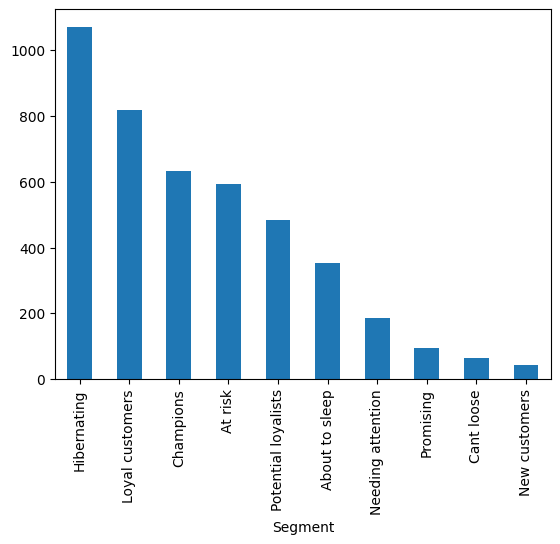

In [288]:
rfm['Segment'].value_counts().plot(kind="bar")

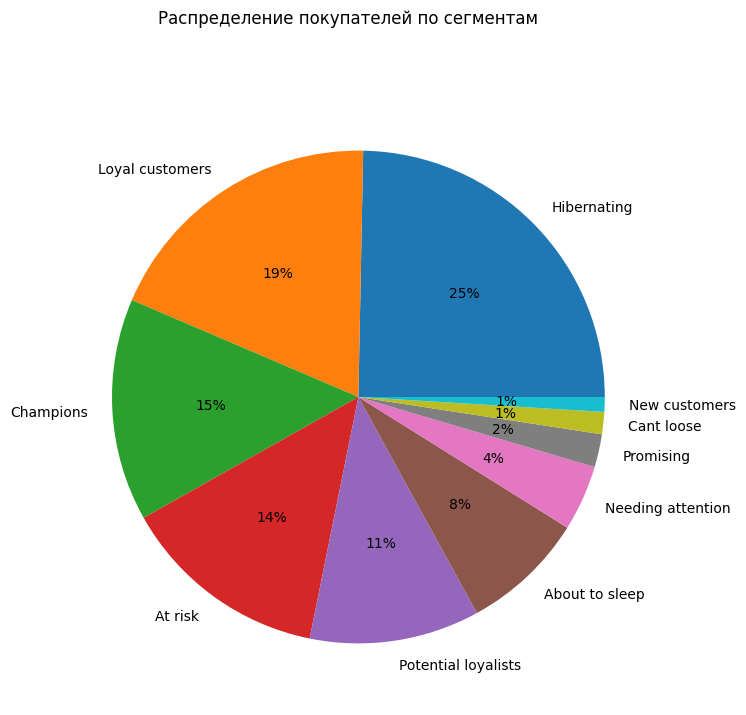

In [289]:
fig  = plt.figure(figsize = (8,8)).suptitle('Распределение покупателей по сегментам')
plt.pie(segments_count['Count'], labels = segments_count['Segment'], autopct='%.0f%%')
plt.show()

In [290]:
# Количество уникальных покупателей
df['CustomerID'].nunique()

4338

Бездействующие (Hibernating) клиенты — самый крупный сегмент, составляет 25%

In [291]:
print('Процент бездействующих покупателей', round((1071 / df['CustomerID'].nunique()) * 100, 2))

Процент бездействующих покупателей 24.69


In [292]:
rfm[rfm['RFM_Score'] == '11'].head()

,CustomerID,Recency,Frequency,Monetary,Recency_score,Frequency_score,Monetary_score,RFM_Score,Segment
0,12346.0,327,1,77183.6,1,1,5,11,Hibernating
4,12350.0,312,1,334.4,1,1,2,11,Hibernating
6,12353.0,206,1,89.0,1,1,1,11,Hibernating
7,12354.0,234,1,1079.4,1,1,4,11,Hibernating
8,12355.0,216,1,459.4,1,1,2,11,Hibernating


Лучшим сегментом считается Champions, поскольку они тратят больше всех, покупают товары часто и покупали их недавно.

In [293]:
rfm[rfm['RFM_Score'] == '55'].head()

,CustomerID,Recency,Frequency,Monetary,Recency_score,Frequency_score,Monetary_score,RFM_Score,Segment
1,12347.0,4,7,4310.00,5,5,5,55,Champions
15,12362.0,5,10,5226.23,5,5,5,55,Champions
56,12417.0,5,9,3649.10,5,5,5,55,Champions
61,12423.0,2,8,1859.31,5,5,4,55,Champions
71,12433.0,2,7,13375.87,5,5,5,55,Champions


In [294]:
rfm[['Segment', 'Recency', 'Frequency', 'Monetary']].groupby('Segment').agg(['mean', 'count', 'max'])

Recency             Frequency                Monetary  \
                           mean count  max       mean count  max         mean   
Segment                                                                         
About to sleep        54.312500   352   73   1.161932   352    2   469.893437   
At risk              154.785835   593  375   2.876897   593    6  1080.920373   
Cant loose           133.968254    63  374   8.380952    63   34  2790.101429   
Champions              7.361769   633   14  12.413902   633  209  6843.160521   
Hibernating          218.605042  1071  375   1.101774  1071    2   487.628909   
Loyal customers       34.608059   819   73   6.479853   819   63  2855.791173   
Needing attention     53.427807   187   73   2.326203   187    3   892.505936   
New customers          8.428571    42   14   1.000000    42    1   385.022381   
Potential loyalists   18.398760   484   34   2.010331   484    3  1036.483099   
Promising             24.510638    94   34   1.000000    94    1   292.050213   

                                      
                    count        max  
Segment                               
About to sleep        352    6207.67  
At risk               593   44534.30  
Cant loose             63   10254.18  
Champions             633  280206.02  
Hibernating          1071   77183.60  
Loyal customers       819  124914.53  
Needing attention     187   12601.83  
New customers          42    3861.00  
Potential loyalists   484  168472.50  
Promising              94    1757.55

Благодаря RFM-анализу можно  
Поддерживать лояльность ключевых клиентов - сообщать им про новинки и актуальные акции  
Реактивировать клиентов, которые делали покупки - дать спецпредложение или промокод  
Мотивировать покупать чаще тех, кто покупает редко, но на большую сумму - предлагать большие бонусы  
Реактивировать уснувших клиентов - использовать таргетированную рекламу

# Кластеризация методом k-средних (k-means)

In [295]:
df_cl = df.copy()
df_cl['TotalPrice'] = df_cl['Quantity'] * df_cl['UnitPrice']
df_cl['InvoiceDate'] = pd.to_datetime(df_cl['InvoiceDate'])
df_cl = df_cl.groupby('CustomerID').agg({'InvoiceDate': lambda InvoiceDate: (today - InvoiceDate.max()).days,
                                    'InvoiceNo'    : lambda InvoiceNo: InvoiceNo.nunique(),
                                    'TotalPrice' : lambda TotalPrice: TotalPrice.sum()})

df_cl.columns = ['Recency', 'Frequency', 'Monetary']

In [296]:
df_cl.head()

,Recency,Frequency,Monetary
CustomerID,,,
12346.0,327,1,77183.60
12347.0,4,7,4310.00
12348.0,77,4,1797.24
12349.0,20,1,1757.55
12350.0,312,1,334.40


## Стандартизация данных

In [298]:
ss = StandardScaler()
df_scaled = ss.fit_transform(df_cl)
df_scaled = pd.DataFrame(df_scaled, columns=['Recency', 'Frequency', 'Monetary'])
df_scaled['CustomerID'] = df_cl.index
df_scaled = df_scaled.set_index('CustomerID', drop=True)

## Определение числа кластеров

Определим количество кластеров методом локтя.

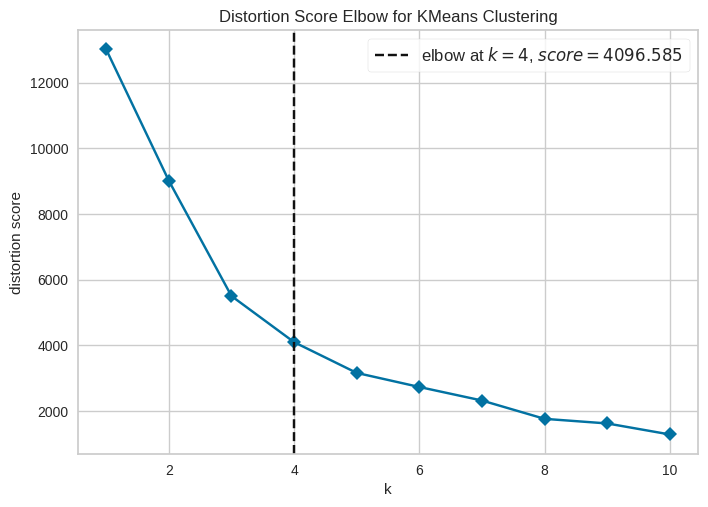

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [302]:
model = KMeans(n_init='auto')
vis = KElbowVisualizer(model, k=(1,11), timings=False)
vis.fit(df_scaled)
vis.show()

## Применение метода k-means

In [303]:
kmeans = KMeans(n_clusters=4, n_init=15)
kmeans.fit(df_scaled)

KMeans(n_clusters=4, n_init=15)

In [304]:
df_labels = pd.DataFrame(kmeans.labels_ , columns = list(['labels']))
df_labels['labels'] = df_labels['labels'].astype('category')

In [305]:
df_kmeans = df_cl.copy()
df_kmeans['labels'] = df_labels['labels'].values

In [306]:
df_kmeans.head()

,Recency,Frequency,Monetary,labels
CustomerID,,,,
12346.0,327,1,77183.60,3
12347.0,4,7,4310.00,0
12348.0,77,4,1797.24,0
12349.0,20,1,1757.55,0
12350.0,312,1,334.40,1


## Визуализация данных

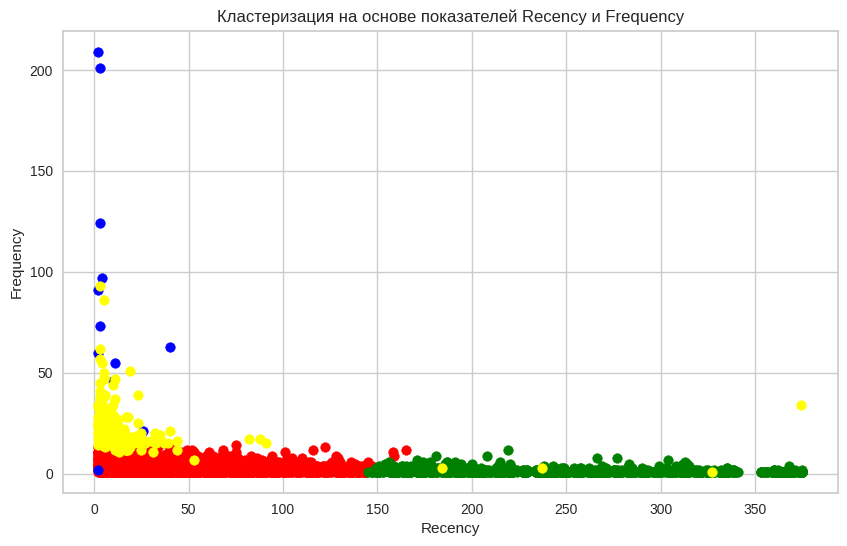

In [336]:
plt.figure(figsize=(10, 6))
colors = ['red', 'green', 'blue', 'yellow']
for i in range(4):
    cluster_data = df_kmeans[df_kmeans['labels'] == i]
    plt.scatter(cluster_data['Recency'], cluster_data['Frequency'], color=colors[i])
plt.xlabel('Recency')
plt.ylabel('Frequency')
plt.title('Кластеризация на основе показателей Recency и Frequency')
plt.show()

Кластер 0 имеет низкий показатель Recency и Frequency (покупали недавно, нечасто)   
Кластер 1 имеет низкий показатель Frequency, и более высокий показатель Recency
(покупают редко и нечасто)
Кластер 2 имеет низкий показатель Recency, но высокие показатели Frequency (покупают часто и много)  
Кластер 3 аналогично кластеру 2, только с большим диапазоном Recency (в основном покупают часто и много, но меньше кластера 2)

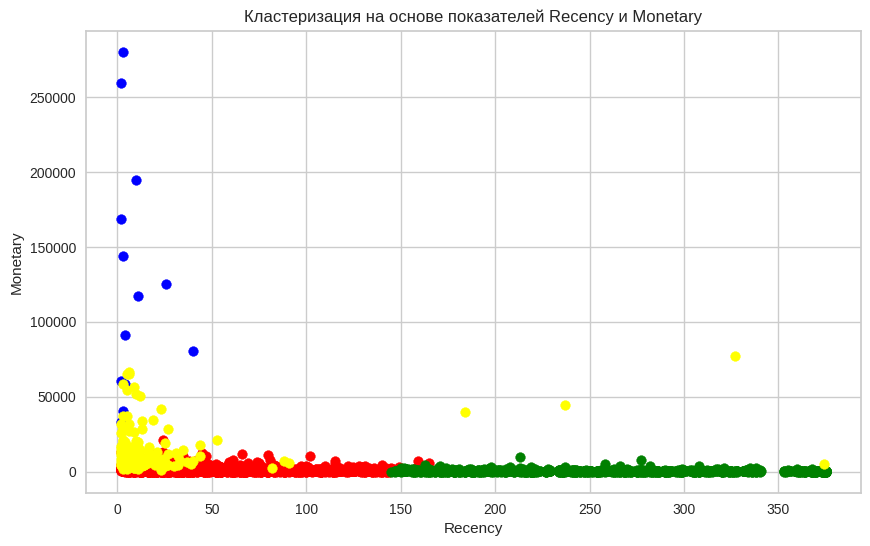

In [335]:
plt.figure(figsize=(10, 6))
for i in range(4):
    cluster_data = df_kmeans[df_kmeans['labels'] == i]
    plt.scatter(cluster_data['Recency'], cluster_data['Monetary'], color=colors[i])
plt.xlabel('Recency')
plt.ylabel('Monetary')
plt.title('Кластеризация на основе показателей Recency и Monetary')
plt.show()

Кластеры 0 и 1 тратили мало денег на покупки  
Кластер 2 совершал самые дорогие покупки в короткие сроки  
Кластер 3 совершал более дешевые покупки, но дороже кластеров 0 и 1 и в основном в короткие сроки

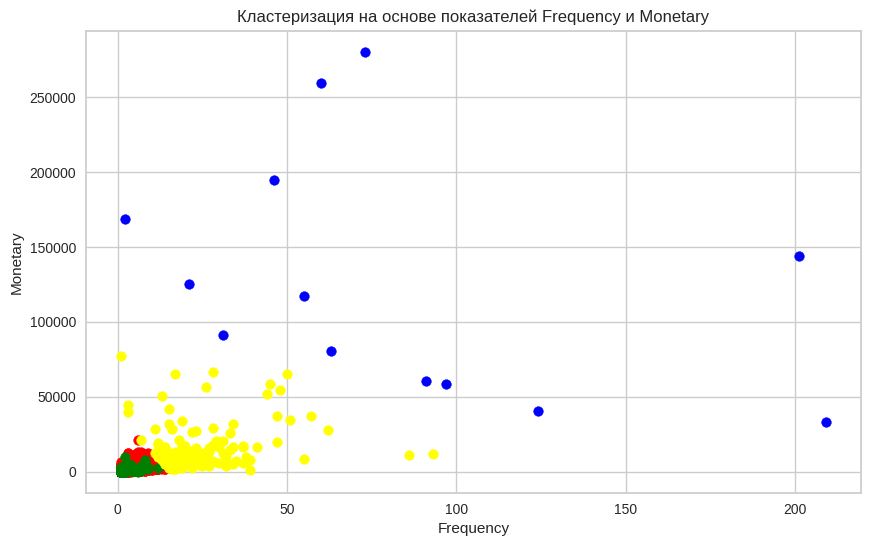

In [337]:
plt.figure(figsize=(10, 6))
for i in range(4):
    cluster_data = df_kmeans[df_kmeans['labels'] == i]
    plt.scatter(cluster_data['Frequency'], cluster_data['Monetary'], color=colors[i])
plt.xlabel('Frequency')
plt.ylabel('Monetary')
plt.title('Кластеризация на основе показателей Frequency и Monetary')
plt.show()

Кластеры 0 и 1 примерно одинаковые в показателях частоты и денег

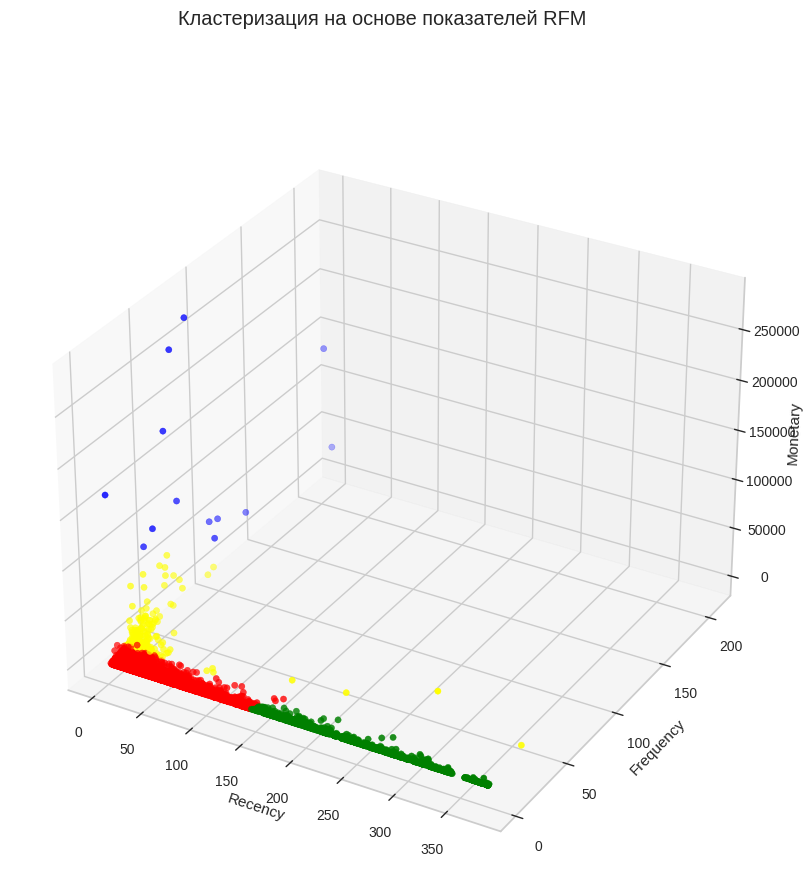

In [326]:
colors = np.array(['red', 'green', 'blue', 'yellow'])
fig  = plt.figure(figsize = (10,10)).suptitle('Кластеризация на основе показателей RFM')
ax = plt.axes(projection='3d')
ax.scatter3D(df_kmeans['Recency'], df_kmeans['Frequency'], df_kmeans['Monetary'], marker='o', c=colors[df_kmeans['labels'].tolist()])
ax.set_xlabel('Recency')
ax.set_ylabel('Frequency')
ax.set_zlabel('Monetary')
plt.show()

In [342]:
df_kmeans['labels'].value_counts()

labels
0    3060
1    1061
3     204
2      13
Name: count, dtype: int64

Больше всего человек в Кластере 0 и 1, они являются основными покупателями. В Кластере 2 всего 13 человек, но они самые прибыльные

In [ ]:
df_kmeans = df_kmeans.reset_index()

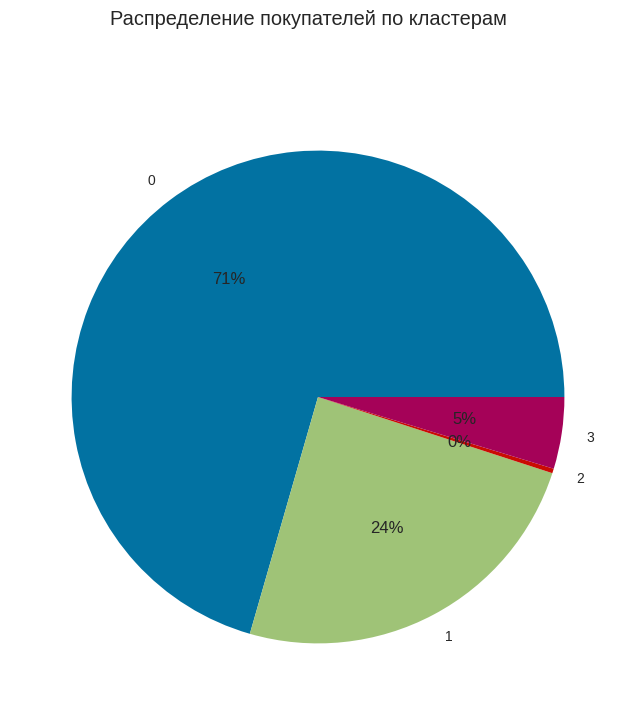

In [356]:
clusters_count = df_kmeans.groupby('labels').agg({'CustomerID': 'count'})
clusters_count.reset_index(inplace=True)
clusters_count.columns = ['cluster', 'count']

fig  = plt.figure(figsize = (8,8)).suptitle('Распределение покупателей по кластерам')
plt.pie(clusters_count['count'], labels = clusters_count['cluster'], autopct='%.0f%%')

plt.show()

Кластер 0 - покупает регулярно  
Кластер 1 - Hibernating - покупают редко, нечасто, тратят мало денег
Кластер 2: лучшие покупатели, мы хотим их удерживать, потому что тратят много денег, часто и недавно  
Кластер 3: недавние активные покупатели

<ipython-input-367-7f3a740ed218>:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='labels', y='Recency', data=df_kmeans, palette=colors)


<Axes: xlabel='labels', ylabel='Recency'>

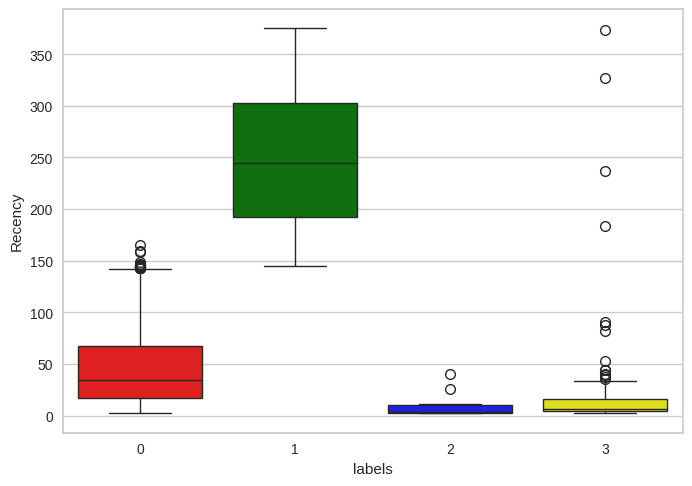

In [367]:
sns.boxplot(x='labels', y='Recency', data=df_kmeans, palette=colors)

Кластер 1 очень давно совершал покупки, Кластеры 2 и 3 совершали их совсе недавно. Но в Кластере 3 много выбросов.

<ipython-input-368-d6d6b4ef9a98>:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='labels', y='Frequency', data=df_kmeans, palette=colors)


<Axes: xlabel='labels', ylabel='Frequency'>

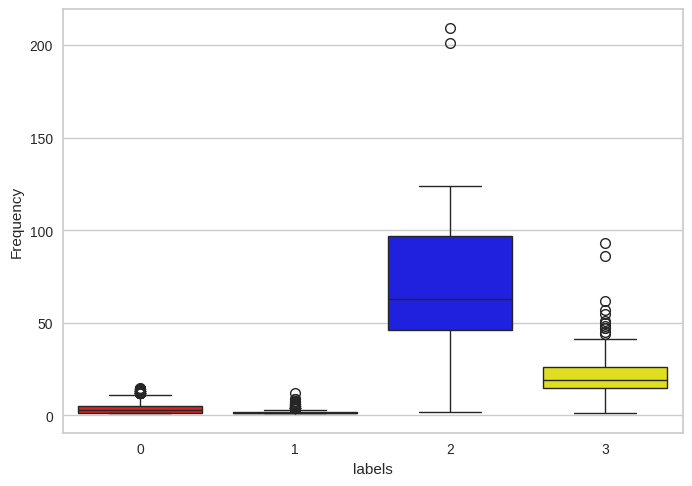

In [368]:
sns.boxplot(x='labels', y='Frequency', data=df_kmeans, palette=colors)

<ipython-input-369-4df04ebc0b41>:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='labels', y='Monetary', data=df_kmeans, palette=colors)


<Axes: xlabel='labels', ylabel='Monetary'>

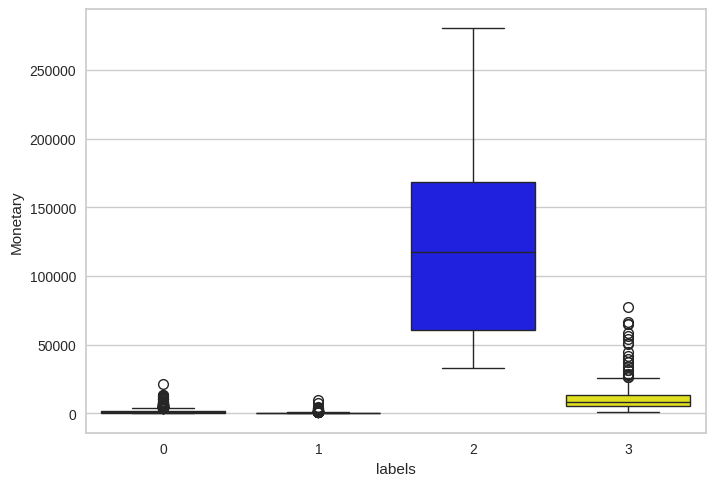

In [369]:
sns.boxplot(x='labels', y='Monetary', data=df_kmeans, palette=colors)

Кластер 2 совершал самые дорогие покупки

# Выводы

В RFM-анализе благодаря большому количеству видов клиентов не получилось преобладания какого-то из кластеров в данных. А алгоритм k-means отнес большую часть клиентов в кластер где 71% всех людей и на топовых покупателей оставил 0.4%. Однако, алгоритм четко разделил покупателей по RFM критериям. Благодаря нему мы выяснили, какие покупатели самые прибыльные и выгодные.